## Neural Network

This jupyter notebook implements the neural network model using convolutional layers

In [140]:
#Import libraries
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import os
from sklearn.metrics import recall_score, accuracy_score, f1_score
import numpy as np
from XRayDataset import XRayDataset
from dataloader import train_path, test_path, val_path
import matplotlib.pylab as plt
%matplotlib inline

In [141]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.LeNet = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Flatten(),
            nn.Linear(16 * 61 * 61, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2)
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out


In [142]:
model = CustomNeuralNetwork()

In [143]:
#Dataloader code from Checkpoint #1
resize = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.Resize((int(256), int(256))), # Resize the image to match median ratio using median length, we can try later with smaller length 
            T.ToTensor()
        ])
 
transforms = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.RandomAdjustSharpness(sharpness_factor=10),
            T.ColorJitter(brightness=.5, hue=.3),
            T.Resize((int(256), int(256))),
            # Resize the image to match median ratio using median length 
            T.ToTensor()
        ])
training_data = XRayDataset(train_path, transforms)
val_data = XRayDataset(val_path, resize)
test_data = XRayDataset(test_path, resize)

#Discussion with Ian said to start with small batches (2,4)
#Medium post said do powers of 2 starting with 16 
#I'll go with middle point and do batch = 8
#https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15

batch_s = 64

train_dataloader = DataLoader(training_data, batch_size=batch_s, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_s, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_s, shuffle=True)


In [144]:
# 3: Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss() #a.Change the cross entropy of the original code to NLL 
#which we have used before for binary classification
#b. 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train(model):
    EPOCHS = 1
    train_losses = []
    train_accuracies = []
    train_recalls = []
    for _ in range(EPOCHS):
        # TRAIN
        model.train()  # Make sure gradient tracking is on, and do a pass over the data
        running_loss = 0.0
        y_true = np.array([])
        y_predict = np.array([])
        for i, data in enumerate(train_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward pass
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            loss = criterion(outputs, labels_tensor)  # calculate loss
            loss.backward()  # backward pass
            optimizer.step()  # update weights
            running_loss += loss.item()
            y_true = np.concatenate((y_true, labels_tensor.numpy()))
            y_pred_batch = np.argmax(outputs.detach().numpy(), axis=1)
            y_predict = np.concatenate((y_predict, y_pred_batch))
        
        epoch_accuracy = (y_predict == y_true).mean()
        epoch_recall = recall_score(y_true, y_predict, average='binary')
        train_losses.append(running_loss)
        train_accuracies.append(epoch_accuracy)
        train_recalls.append(epoch_recall)
    
    return y_predict, y_true, train_losses, train_accuracies, train_recalls

In [145]:
y_predict, y_true, train_losses, train_accuracies, train_recalls = train(model)

print("y_predict", y_predict)
print("y_true", y_true)
print(train_losses)
print(train_accuracies)
print(train_recalls)

KeyboardInterrupt: 

In [ ]:
def validate(model): 
    # 4: Train and validate the network
    EPOCHS = 3
    val_losses = []
    val_accuracies = []
    val_recalls = []
    for _ in range(EPOCHS):
        # VAL
        model.eval()  # # we don't want to keep track of the gradients in the validation part
        val_running_loss = 0.0
        y_true_val = np.array([])
        y_predict_val = np.array([])
        for i, data in enumerate(val_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(inputs)  # forward pass
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            loss = criterion(outputs, labels_tensor)  # calculate loss
            loss.backward()  # backward pass
            optimizer.step()  # update weights
            val_running_loss += loss.item()
            y_true_val = np.concatenate((y_true_val, labels_tensor.numpy()))
            y_predict_val = np.concatenate((y_predict_val, outputs.argmax(dim=1).numpy()))

        val_epoch_accuracy = (y_predict_val == y_true_val).mean()
        val_epoch_recall = recall_score(y_true_val, y_predict_val, average='binary')
        val_losses.append(val_running_loss)
        val_accuracies.append(val_epoch_accuracy)
        val_recalls.append(val_epoch_recall)

    return val_accuracies, val_losses, val_recalls, y_predict_val

In [ ]:
val_accuracies, val_losses, val_recalls, y_predict_val = validate(model)

print(val_accuracies)
print(val_losses)
print(val_recalls)

unique, counts = np.unique(y_predict_val, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

[0.5, 0.4375, 0.5]
[0.6931960582733154, 0.6932294368743896, 0.6932607293128967]
[1.0, 0.625, 0.125]
0.0: 14
1.0: 2


In [ ]:
def test(model):
    #5. Test model
    EPOCHS = 1
    test_losses = []
    test_accuracies = []
    test_recalls = []
    with torch.no_grad():
        for _ in range(EPOCHS):
            # TEST
            model.train()  # Make sure gradient tracking is on, and do a pass over the data
            test_running_loss = 0.0
            y_true_test = np.array([])
            y_predict_test = np.array([])
            for i, data in enumerate(test_dataloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                optimizer.zero_grad()  # zero the parameter gradients
                outputs = model(inputs)  # forward pass
                # print("OUTPUTS: ", outputs)
                label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
                labels_tensor = torch.tensor([label_dict[label] for label in labels])
                loss = criterion(outputs, labels_tensor)  # calculate loss
                optimizer.step()  # update weights
                test_running_loss += loss.item()
                y_true_test = np.concatenate((y_true_test, labels_tensor.numpy()))
                y_predict_test = np.concatenate((y_predict_test, outputs.argmax(dim=1).numpy()))

            test_epoch_accuracy = (y_predict_test == y_true_test).mean()
            test_epoch_recall = recall_score(y_true_test, y_predict_test, average='binary')
            test_losses.append(test_running_loss)
            test_accuracies.append(test_epoch_accuracy)
            test_recalls.append(test_epoch_recall)
  
    return test_accuracies, test_losses, test_recalls, y_predict_test

In [ ]:
test_accuracies, test_losses, test_recalls, y_predict_test = test(model)

print(test_accuracies)
print(test_losses)
print(test_recalls)

unique, counts = np.unique(y_predict_test, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")


[0.625]
[6.727352440357208]
[0.0]
0.0: 624


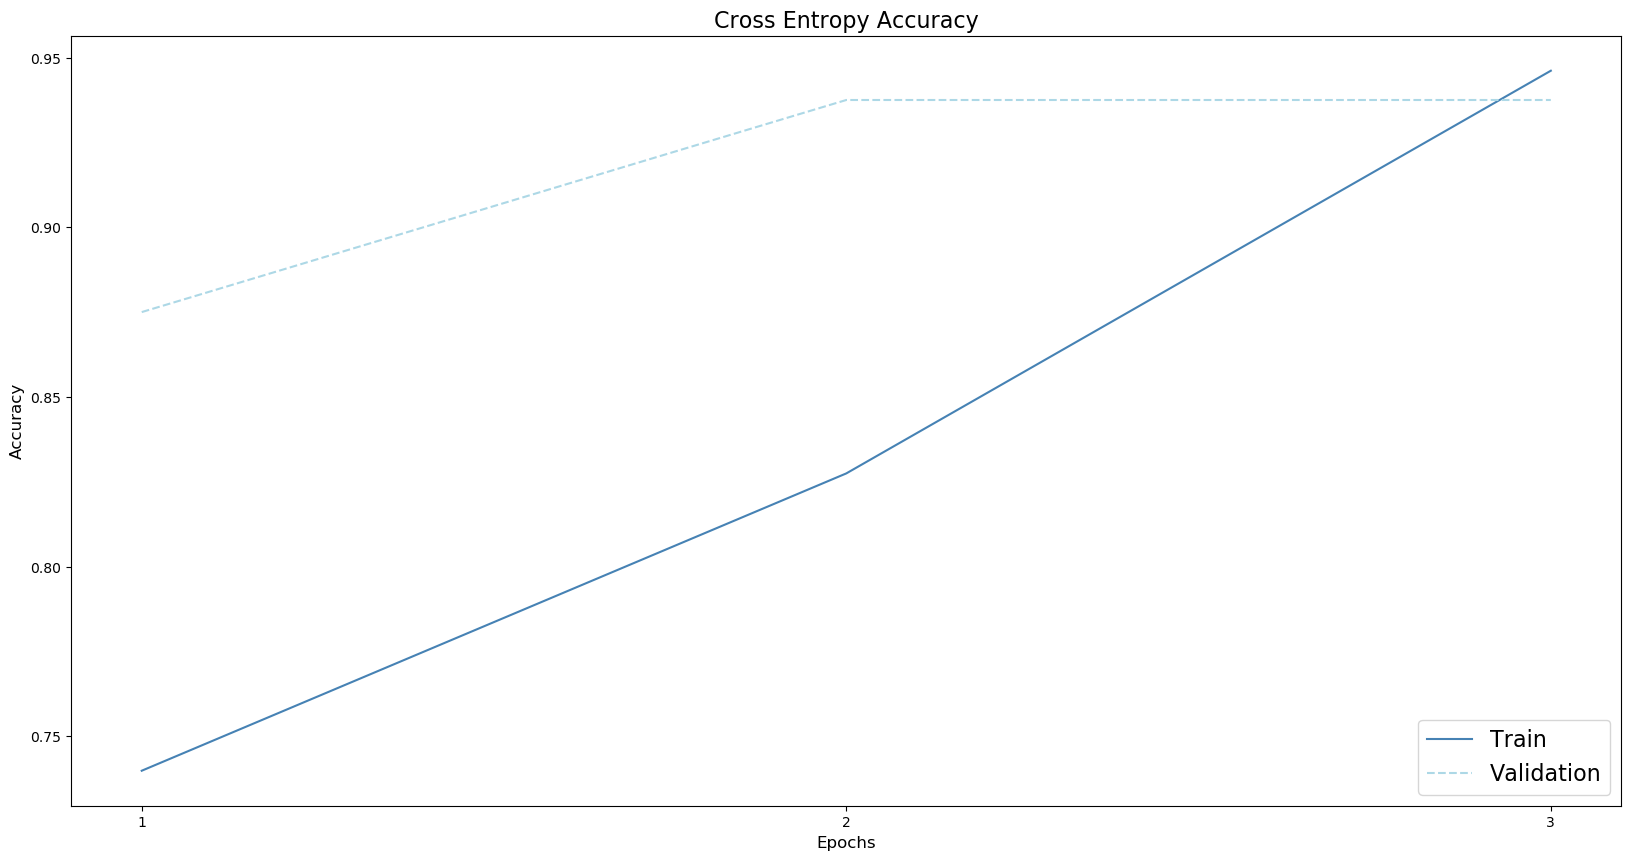

In [ ]:
EPOCHS = 10 # get rid of test data
epochs = [i for i in range(1,EPOCHS+1)]

y_predict, y_true, train_losses, train_accuracies, train_recalls = train(model)
val_accuracies, val_losses, val_recalls, y_predict_val = validate(model)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies, color="lightblue", ls='dashed', label='Validation')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Cross Entropy Accuracy", fontsize=16)
plt.show()

In [ ]:
print("y_predict", y_predict)
y_predict_cross_3 = y_predict.copy()
print("y_true", y_true)
y_true_cross_3 = y_true.copy()
print(train_losses)
train_losses_cross_3 = train_losses.copy()
print(train_accuracies)
train_accuracies_cross_3 = train_accuracies.copy() 
print(train_recalls)
train_recalls_cross_3 = train_recalls
train_recalls_cross_3

y_predict [0. 0. 0. ... 0. 0. 0.]
y_true [0. 0. 1. ... 0. 0. 0.]
[46.63114356994629, 37.916432946920395, 30.921327620744705]
[0.7398389570552147, 0.8274539877300614, 0.9461273006134969]
[0.01715137956748695, 0.36092468307233405, 0.8672632363907532]


[0.01715137956748695, 0.36092468307233405, 0.8672632363907532]

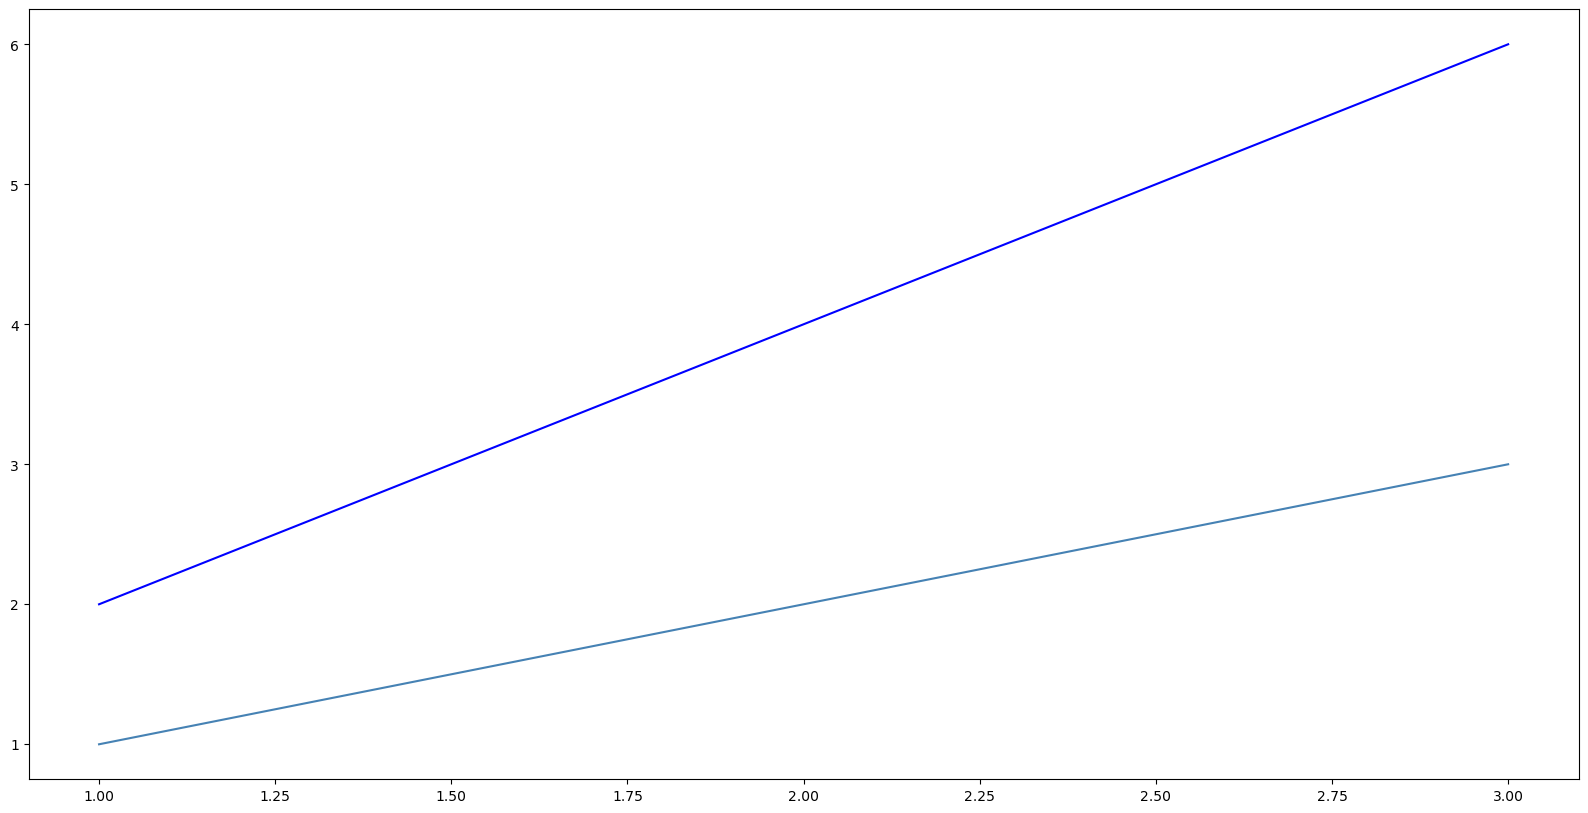

In [ ]:
epochs = [3, 10]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
# ax.plot(epochs, test_accuracy_NLL, color="steelblue", label= 'NLL')
ax.plot(epochs, test_accuracies, color="lightblue", ls='dashed', label='Cross Entropy')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Testing Accuracy", fontsize=16)
plt.show()